In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.mixture import GaussianMixture
#run kmeans and gaussian and interpret, keep how many clusters i need and change
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.special import entr
import plotly.express as px


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()
#print(df['netmargin'])

0        -3.765
1       -38.489
2        -3.877
3        -3.689
4        -1.144
          ...  
40272     0.089
40273     0.118
40274     0.135
40275     0.109
40276     0.090
Name: netmargin, Length: 40277, dtype: float64


In [3]:
df.shape #check the number of rows and cols

(40277, 31)

In [4]:
df.info() #checking the types of the data we have 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

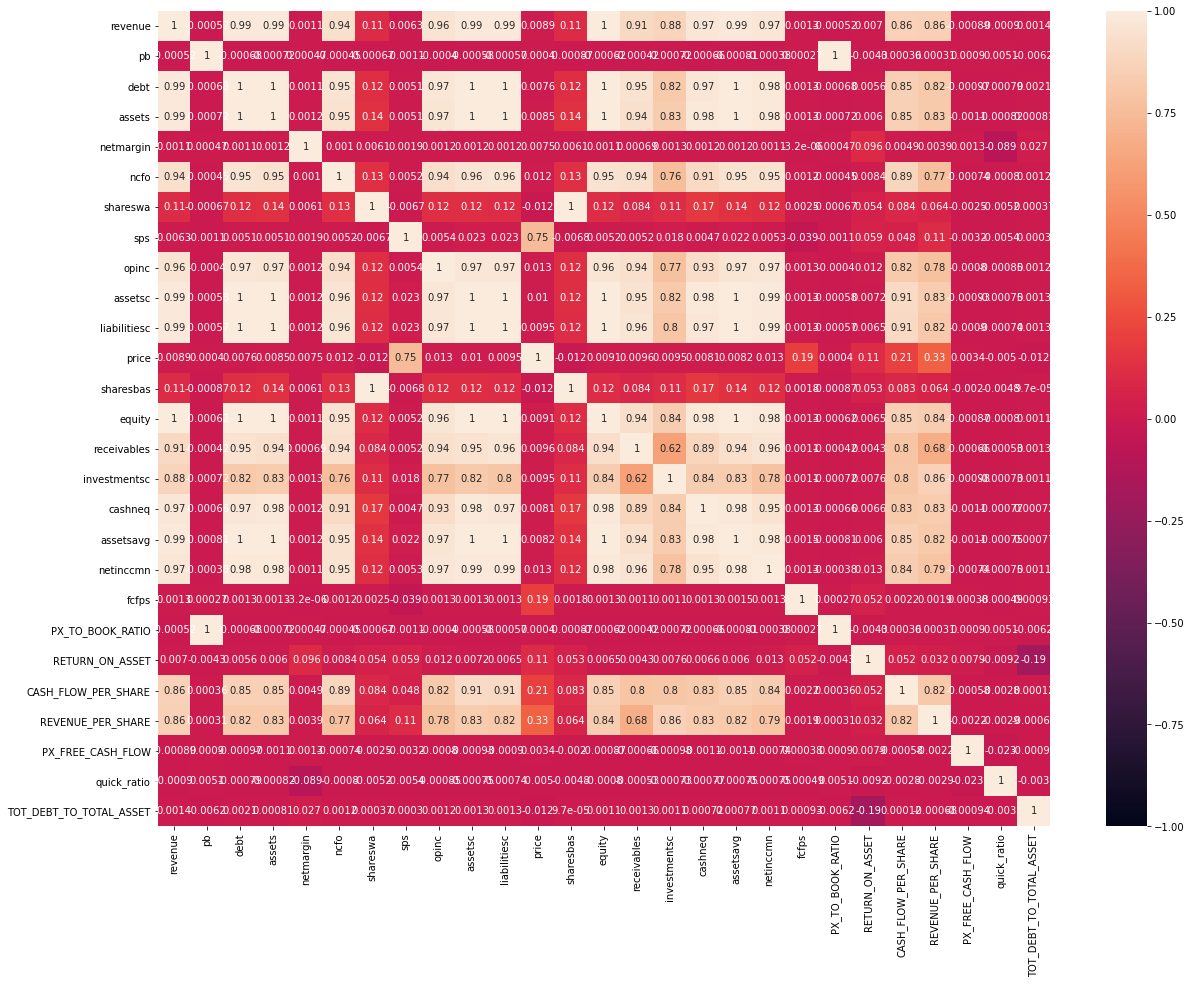

In [5]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [6]:
df['datekey'].nunique()
#i see that i have two types of dates above: datekey and calendardate. Checking how many rows of datekey I have

584

In [7]:
(df['datekey'] == df['calendardate']).mean() # 83% they match, I see that they're highly correlated, so I can drop one of them.


0.8301015467884897

In [8]:
df['calendardate'].unique() 
#deciding which quarter to pick. Futher I'll investigate clusters based on the chosen dates.

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [9]:
df['calendardate'] = pd.to_datetime(df['calendardate'])
df.head()

ticker     revenue     pb       debt       assets  netmargin        ncfo  \
0   ZYME   8269000.0  3.091  9007000.0  636578000.0     -3.765 -37487000.0   
1   ZYME   1877000.0  7.288  6881000.0  368205000.0    -38.489 -36354000.0   
2   ZYME   7860000.0  3.146  6755000.0  400037000.0     -3.877 -10880000.0   
3   ZYME   7882000.0  2.112  7829000.0  414547000.0     -3.689 -13317000.0   
4   ZYME  11925000.0  3.048  8065000.0  238279000.0     -1.144 -21302000.0   

     shareswa    sps       opinc  ...    netinccmn  fcfps  PX_TO_BOOK_RATIO  \
0  48686718.0  0.170 -35880000.0  ... -162932000.0 -2.154             3.091   
1  43658717.0  0.043 -73752000.0  ... -145437000.0 -2.319             7.288   
2  43445379.0  0.181 -33564000.0  ...  -63920000.0  0.004             3.146   
3  32837975.0  0.240 -29432000.0  ...  -52196000.0  0.028             2.112   
4  32020437.0  0.372 -14553000.0  ...  -28993000.0  0.616             3.048   

  RETURN_ON_ASSET   OPER_MARGIN  CASH_FLOW_PER_SHARE  REVENUE_PER_SHARE  \
0       -0.358217  -4.339097835            -0.823549           0.181661   
1       -0.409374  -39.29248801            -0.922987           0.047655   
2       -0.197080  -4.270229008            -0.277127           0.200204   
3       -0.191239  -3.734077645            -0.415356           0.245839   
4       -0.130571  -1.220377358            -0.665162           0.372362   

   PX_FREE_CASH_FLOW  quick_ratio  TOT_DEBT_TO_TOTAL_ASSET  
0         -16.467038     6.807722                 0.014149  
1         -19.603277     3.647265                 0.018688  
2        6200.000000     6.678431                 0.016886  
3         785.714286     8.874183                 0.018886  
4          26.266234     6.440652                 0.033847  

[5 rows x 31 columns]

In [10]:
#picked the dates 
df = df[df['calendardate'].between('2019-10-01', '2020-01-01')]
df.head()
print(df['netmargin'])

1       -38.489
16       -0.337
30        0.229
51       -0.288
65       -0.009
          ...  
40175     0.131
40196    -0.107
40217     0.037
40238    -0.124
40257     0.145
Name: netmargin, Length: 2017, dtype: float64


In [11]:
from scipy.stats.mstats import winsorize
import scipy.stats

#converting operating margin to a numerical data, apparently there's a bad data, which is giving it as an object.

df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA

#q = df["netmargin"].quantile(0.80)
#df[df["netmargin"] < q]
q_low = df["OPER_MARGIN"].quantile(0.1)
q_hi  = df["OPER_MARGIN"].quantile(0.80)

df_filtered = df[(df["OPER_MARGIN"] < q_hi) & (df["OPER_MARGIN"] > q_low)]

#at this point I'm trying all the possible ways to see if netmargin values are going to change. My attempts don't end here
#you'll see my attempts below too


plt.hist(round(df_filtered['OPER_MARGIN'], 2), bins = 10)

In [12]:
#I'm checking if the data has the stocks I'm interested in. 
#So I realized looking at the output that it doesn't have all the stocks in the market. Also that stocks in the dataset 
#are more stable ones, so called 'long term growth stocks' but no penny stocks found.

df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ', 'GLIBA', 'MRVL', 'NLOK'])] #can drop quick_ratio or drop HTZ, GE

ticker       revenue       pb          debt        assets  netmargin  \
15152   NLOK  6.180000e+08    1.855  4.592000e+09  1.854700e+10      4.604   
15741   NCLH  1.480618e+09    1.907  6.801693e+09  1.668460e+10      0.082   
16554   MRVL  7.176710e+08    1.858  1.439024e+09  1.113324e+10      2.470   
22792    HTZ  2.325000e+09    1.265  1.893700e+10  2.462700e+10     -0.051   
24871  GLIBA  2.323870e+08    1.207  3.363725e+09  1.193344e+10      3.063   
25128     GE  1.573700e+10    3.442  9.088200e+10  2.660480e+11      0.034   
36147     BA  1.791100e+10  -21.276  2.730200e+10  1.336250e+11     -0.056   
38187    AMD  2.127000e+09   18.191  6.850000e+08  6.028000e+09      0.080   
40217    AAL  1.131300e+10 -106.470  3.344400e+10  5.999500e+10      0.037   

               ncfo      shareswa     sps         opinc  ...     netinccmn  \
15152  3.990000e+08  6.210000e+08   0.995  6.200000e+07  ...  3.690000e+09   
15741  3.418510e+08  2.128776e+08   6.955  1.993760e+08  ...  9.302280e+08   
16554  5.583800e+07  6.572840e+08   1.092 -1.144950e+08  ...  1.584391e+09   
22792  6.670000e+08  1.170000e+08  19.872  8.900000e+07  ... -5.800000e+07   
24871  6.491000e+06  1.056511e+08   2.200 -1.644500e+08  ...  1.938698e+09   
25128  6.739000e+09  8.733549e+09   1.802  2.186000e+09  ... -5.439000e+09   
36147 -2.220000e+09  5.627912e+08  31.825 -2.599000e+09  ... -6.360000e+08   
38187  4.420000e+08  1.139000e+09   1.867  3.480000e+08  ...  3.410000e+08   
40217  6.000000e+08  4.380580e+08  25.825  7.290000e+08  ...  1.686000e+09   

        fcfps  PX_TO_BOOK_RATIO RETURN_ON_ASSET   OPER_MARGIN  \
15152   2.113             1.855        0.223355   0.100323625   
15741   0.863             1.907        0.057823   0.134657285   
16554   0.413             1.858        0.152838  -0.159536891   
22792 -13.034             1.265       -0.002307    0.03827957   
24871  -0.567             1.207        0.180488  -0.707655764   
25128   0.732             3.442       -0.018816   0.138908305   
36147  -7.011           -21.276       -0.004962  -0.145106359   
38187   0.253            18.191        0.063995   0.163610719   
40217  -0.911          -106.470        0.027648   0.064439141   

       CASH_FLOW_PER_SHARE  REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  \
15152             0.640445           0.991967          12.224326     2.745385   
15741             1.606763           6.959180          67.682503     0.091504   
16554             0.083253           1.070033          58.208232     1.605188   
22792             4.693162          16.359223          -1.208378          NaN   
24871             0.061438           2.199570        -124.955908     1.731435   
25128             0.771622           1.801902          15.245902          NaN   
36147            -3.944624          31.825300         -46.464128     0.253175   
38187             0.396901           1.909974         182.529644     1.425180   
40217             1.369682          25.825349         -31.481888     0.313145   

       TOT_DEBT_TO_TOTAL_ASSET  
15152                 0.247587  
15741                 0.407663  
16554                 0.129255  
22792                 0.768953  
24871                 0.281874  
25128                 0.341600  
36147                 0.204318  
38187                 0.113636  
40217                 0.557446  

[9 rows x 31 columns]

In [13]:
df = df.replace([np.inf, -np.inf], np.nan)
#replacing any irrelevant values to null values

In [14]:
df = df.dropna() #dropping the null values

In [15]:
df.info() #check for infinity how many rows where dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 1 to 40257
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   1493 non-null   object        
 1   revenue                  1493 non-null   float64       
 2   pb                       1493 non-null   float64       
 3   debt                     1493 non-null   float64       
 4   assets                   1493 non-null   float64       
 5   netmargin                1493 non-null   float64       
 6   ncfo                     1493 non-null   float64       
 7   shareswa                 1493 non-null   float64       
 8   sps                      1493 non-null   float64       
 9   opinc                    1493 non-null   float64       
 10  assetsc                  1493 non-null   float64       
 11  liabilitiesc             1493 non-null   float64       
 12  price                    1493 non

In [16]:
#df['calendardate']
df.head()

ticker       revenue      pb          debt        assets  netmargin  \
1    ZYME  1.877000e+06   7.288  6.881000e+06  3.682050e+08    -38.489   
16    ZUO  7.039300e+07  10.140  7.858800e+07  4.022270e+08     -0.337   
30    ZTS  1.674000e+09  23.279  6.611000e+09  1.154500e+10      0.229   
51     ZS  1.012680e+08  22.487  3.444200e+07  6.764250e+08     -0.288   
65   ZNGA  4.044630e+08   2.931  7.165100e+08  3.660614e+09     -0.009   

           ncfo     shareswa    sps        opinc  ...     netinccmn  fcfps  \
1   -36354000.0   43658717.0  0.043  -73752000.0  ... -1.454370e+08 -2.319   
16    4009000.0  113180000.0  0.622  -24449000.0  ... -8.339400e+07 -0.225   
30  582000000.0  476412000.0  3.514  493000000.0  ...  1.500000e+09  2.792   
51    5431000.0  128408000.0  0.789  -30280000.0  ... -6.374200e+07  0.153   
65   94049000.0  947733000.0  0.427    4332000.0  ...  4.192500e+07  0.873   

    PX_TO_BOOK_RATIO RETURN_ON_ASSET   OPER_MARGIN  CASH_FLOW_PER_SHARE  \
1              7.288       -0.409374  -39.29248801            -0.922987   
16            10.140       -0.243414  -0.347321467             0.035415   
30            23.279        0.134270   0.294504182             1.221921   
51            22.487       -0.103884  -0.299008571             0.042444   
65             2.931        0.012826   0.010710498             0.099426   

    REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  TOT_DEBT_TO_TOTAL_ASSET  
1            0.047655         -19.603277     3.647265                 0.018688  
16           0.621846         -65.555556     1.454003                 0.195382  
30           3.514597          47.403295     1.672204                 0.572629  
51           0.791419         366.601307     1.579705                 0.050918  
65           0.427586           7.010309     1.933891                 0.195735  

[5 rows x 31 columns]

In [17]:
df.isna().sum() #no nulls 

ticker                     0
revenue                    0
pb                         0
debt                       0
assets                     0
netmargin                  0
ncfo                       0
shareswa                   0
sps                        0
opinc                      0
assetsc                    0
liabilitiesc               0
price                      0
calendardate               0
datekey                    0
sharesbas                  0
equity                     0
receivables                0
investmentsc               0
cashneq                    0
assetsavg                  0
netinccmn                  0
fcfps                      0
PX_TO_BOOK_RATIO           0
RETURN_ON_ASSET            0
OPER_MARGIN                0
CASH_FLOW_PER_SHARE        0
REVENUE_PER_SHARE          0
PX_FREE_CASH_FLOW          0
quick_ratio                0
TOT_DEBT_TO_TOTAL_ASSET    0
dtype: int64

In [18]:
df = df[~df['ticker'].isin(['AUPH', 'NK', 'ZYME', 'ZGNX', 'LBRDA', 'CRON', 'TM'])] #filtering rows, dont need ~ AUPH AND NK

In [19]:
#for checking the ticker when needed
df_original = df.copy()

In [20]:
keep_cols = ['TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'quick_ratio', 'equity']
df=df[keep_cols]
df.head()

#cleaned the data, these are the features I'll use for clustering stocks.

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  REVENUE_PER_SHARE  \
16                 0.195382         -65.555556           0.621846   
30                 0.572629          47.403295           3.514597   
51                 0.050918         366.601307           0.791419   
65                 0.195735           7.010309           0.427586   
86                 0.050232         156.673511           0.681077   

    CASH_FLOW_PER_SHARE  RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  \
16             0.035415        -0.243414            10.140     1.454003   
30             1.221921         0.134270            23.279     1.672204   
51             0.042444        -0.103884            22.487     1.579705   
65             0.099426         0.012826             2.931     1.933891   
86             0.132249         0.019134            25.289     2.922532   

          equity  
16  1.646590e+08  
30  2.708000e+09  
51  3.191640e+08  
65  1.975430e+09  
86  8.339430e+08

In [21]:
df.corr() #check the correlation between features

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  \
TOT_DEBT_TO_TOTAL_ASSET                 1.000000          -0.011821   
PX_FREE_CASH_FLOW                      -0.011821           1.000000   
REVENUE_PER_SHARE                       0.001637          -0.005071   
CASH_FLOW_PER_SHARE                     0.025166          -0.005650   
RETURN_ON_ASSET                         0.086943           0.052225   
PX_TO_BOOK_RATIO                       -0.045775           0.011261   
quick_ratio                            -0.163286           0.027206   
equity                                 -0.003333          -0.001749   

                         REVENUE_PER_SHARE  CASH_FLOW_PER_SHARE  \
TOT_DEBT_TO_TOTAL_ASSET           0.001637             0.025166   
PX_FREE_CASH_FLOW                -0.005071            -0.005650   
REVENUE_PER_SHARE                 1.000000             0.835269   
CASH_FLOW_PER_SHARE               0.835269             1.000000   
RETURN_ON_ASSET                   0.040790             0.155003   
PX_TO_BOOK_RATIO                 -0.003152            -0.009349   
quick_ratio                      -0.045130            -0.084900   
equity                            0.767746             0.625214   

                         RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  \
TOT_DEBT_TO_TOTAL_ASSET         0.086943         -0.045775    -0.163286   
PX_FREE_CASH_FLOW               0.052225          0.011261     0.027206   
REVENUE_PER_SHARE               0.040790         -0.003152    -0.045130   
CASH_FLOW_PER_SHARE             0.155003         -0.009349    -0.084900   
RETURN_ON_ASSET                 1.000000         -0.017481    -0.116327   
PX_TO_BOOK_RATIO               -0.017481          1.000000     0.005252   
quick_ratio                    -0.116327          0.005252     1.000000   
equity                          0.008256         -0.001603    -0.012018   

                           equity  
TOT_DEBT_TO_TOTAL_ASSET -0.003333  
PX_FREE_CASH_FLOW       -0.001749  
REVENUE_PER_SHARE        0.767746  
CASH_FLOW_PER_SHARE      0.625214  
RETURN_ON_ASSET          0.008256  
PX_TO_BOOK_RATIO        -0.001603  
quick_ratio             -0.012018  
equity                   1.000000

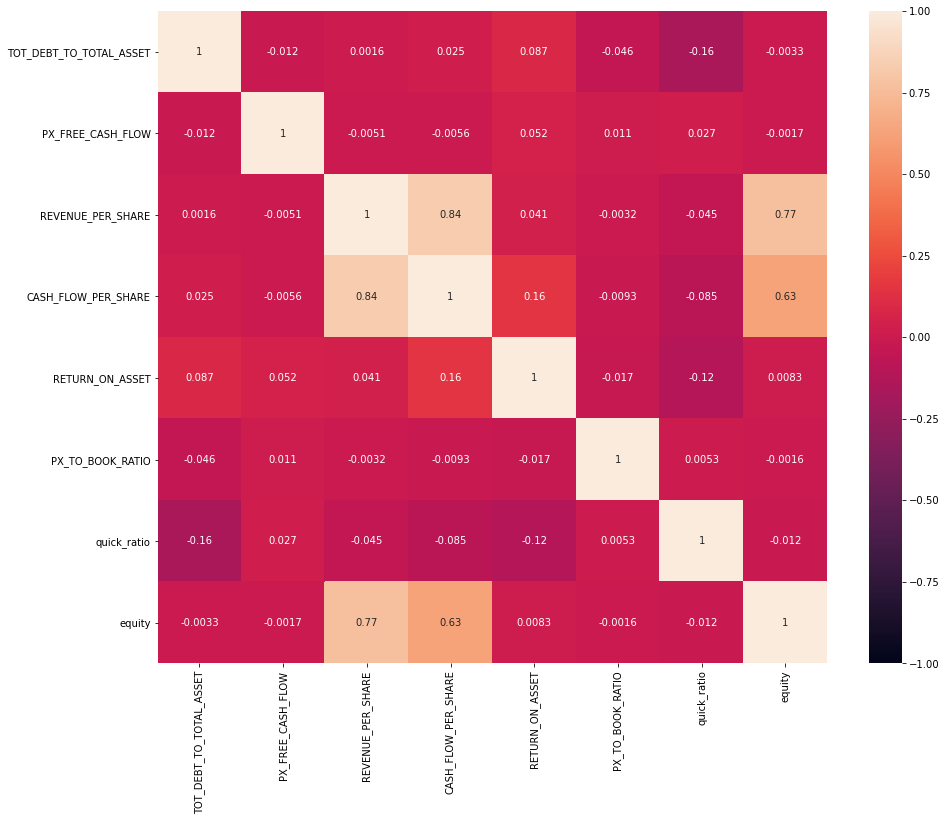

In [22]:
#let's use the visuals - the heatmap to see the correlation
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [23]:
#dropping the highly correlated columns 

drop_cols = ['equity', 'REVENUE_PER_SHARE']
df.drop(drop_cols, axis = 1, inplace=True)
df.head()

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
16                 0.195382         -65.555556             0.035415   
30                 0.572629          47.403295             1.221921   
51                 0.050918         366.601307             0.042444   
65                 0.195735           7.010309             0.099426   
86                 0.050232         156.673511             0.132249   

    RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  
16        -0.243414            10.140     1.454003  
30         0.134270            23.279     1.672204  
51        -0.103884            22.487     1.579705  
65         0.012826             2.931     1.933891  
86         0.019134            25.289     2.922532

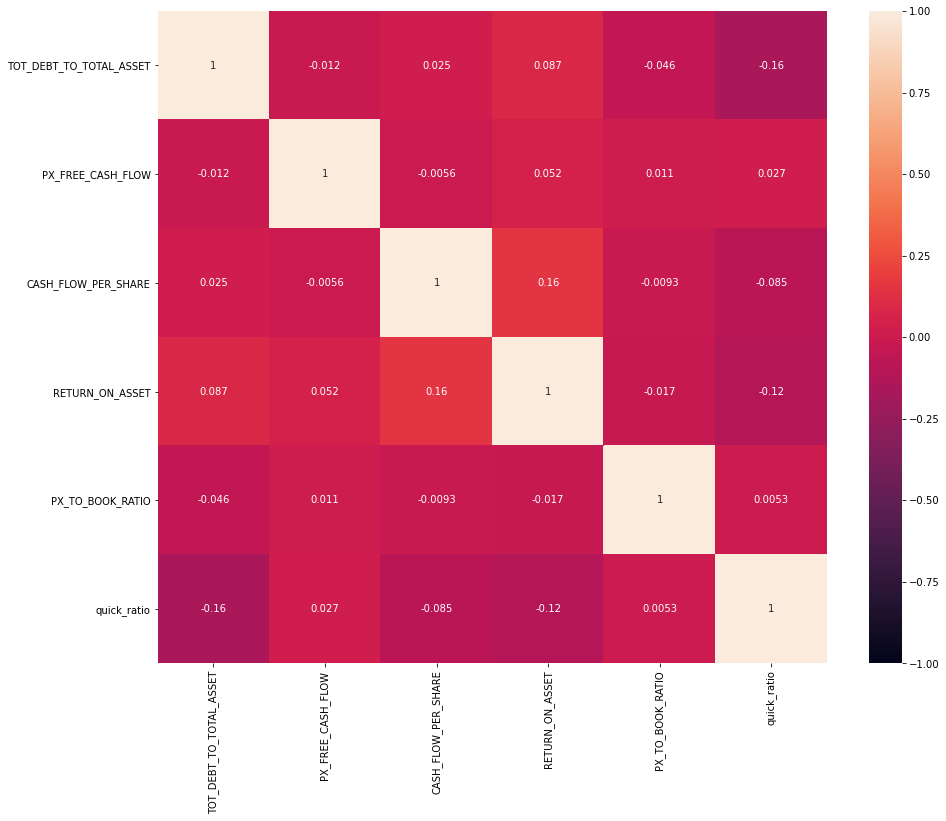

In [24]:
#now the data seems clean

plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [25]:
df.shape

(1486, 6)

In [26]:
#assigning X, y
X = df #clean data
y = df_original

In [27]:
y

ticker       revenue       pb          debt        assets  netmargin  \
16       ZUO  7.039300e+07   10.140  7.858800e+07  4.022270e+08     -0.337   
30       ZTS  1.674000e+09   23.279  6.611000e+09  1.154500e+10      0.229   
51        ZS  1.012680e+08   22.487  3.444200e+07  6.764250e+08     -0.288   
65      ZNGA  4.044630e+08    2.931  7.165100e+08  3.660614e+09     -0.009   
86        ZM  1.882510e+08   25.289  6.479200e+07  1.289845e+09      0.076   
...      ...           ...      ...           ...           ...        ...   
40154    AAP  2.112614e+09    3.090  2.764479e+09  1.124852e+10      0.045   
40175   AAON  1.225740e+08    8.872  0.000000e+00  3.714240e+08      0.131   
40217    AAL  1.131300e+10 -106.470  3.344400e+10  5.999500e+10      0.037   
40238     AA  2.436000e+09    0.971  1.800000e+09  1.463100e+10     -0.124   
40257      A  1.357000e+09    5.282  2.462000e+09  9.501000e+09      0.145   

              ncfo     shareswa     sps        opinc  ...     netinccmn  \
16       4009000.0  113180000.0   0.622  -24449000.0  ... -8.339400e+07   
30     582000000.0  476412000.0   3.514  493000000.0  ...  1.500000e+09   
51       5431000.0  128408000.0   0.789  -30280000.0  ... -6.374200e+07   
65      94049000.0  947733000.0   0.427    4332000.0  ...  4.192500e+07   
86      36554000.0  276679009.0   0.680   10553000.0  ...  2.175000e+07   
...            ...          ...     ...          ...  ...           ...   
40154  158363000.0   69423000.0  30.431  126139000.0  ...  4.868960e+08   
40175   27342000.0   52060833.0   2.354   21430000.0  ...  5.371100e+07   
40217  600000000.0  438057971.0  25.825  729000000.0  ...  1.686000e+09   
40238  262000000.0  185572917.0  13.127 -108000000.0  ... -1.125000e+09   
40257  -59000000.0  310000000.0   4.377  215000000.0  ...  7.640000e+08   

       fcfps  PX_TO_BOOK_RATIO RETURN_ON_ASSET   OPER_MARGIN  \
16    -0.225            10.140       -0.243414  -0.347321467   
30     2.792            23.279        0.134270   0.294504182   
51     0.153            22.487       -0.103884  -0.299008571   
65     0.873             2.931        0.012826   0.010710498   
86     0.487            25.289        0.019134   0.056058135   
...      ...               ...             ...           ...   
40154  8.544             3.090        0.043565   0.059707547   
40175  1.168             8.872        0.155083   0.174833162   
40217 -0.911          -106.470        0.027648   0.064439141   
40238  1.654             0.971       -0.074250  -0.044334975   
40257  1.932             5.282        0.083497    0.15843773   

       CASH_FLOW_PER_SHARE  REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  \
16                0.035415           0.621846         -65.555556     1.454003   
30                1.221921           3.514597          47.403295     1.672204   
51                0.042444           0.791419         366.601307     1.579705   
65                0.099426           0.427586           7.010309     1.933891   
86                0.132249           0.681077         156.673511     2.922532   
...                    ...                ...                ...          ...   
40154             2.286520          30.502923          18.533474     0.247478   
40175             0.524823           2.352777          42.303082     1.995449   
40217             1.369682          25.825349         -31.481888     0.313145   
40238             1.411844          13.126915          13.004837     0.600468   
40257            -0.190210           4.374831          42.732919     1.158562   

       TOT_DEBT_TO_TOTAL_ASSET  
16                    0.195382  
30                    0.572629  
51                    0.050918  
65                    0.195735  
86                    0.050232  
...                        ...  
40154                 0.245764  
40175                 0.000000  
40217                 0.557446  
40238                 0.123026  
40257                 0.259131  

[1486 rows x 31 columns]

In [28]:
X

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
16                    0.195382         -65.555556             0.035415   
30                    0.572629          47.403295             1.221921   
51                    0.050918         366.601307             0.042444   
65                    0.195735           7.010309             0.099426   
86                    0.050232         156.673511             0.132249   
...                        ...                ...                  ...   
40154                 0.245764          18.533474             2.286520   
40175                 0.000000          42.303082             0.524823   
40217                 0.557446         -31.481888             1.369682   
40238                 0.123026          13.004837             1.411844   
40257                 0.259131          42.732919            -0.190210   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  
16           -0.243414            10.140     1.454003  
30            0.134270            23.279     1.672204  
51           -0.103884            22.487     1.579705  
65            0.012826             2.931     1.933891  
86            0.019134            25.289     2.922532  
...                ...               ...          ...  
40154         0.043565             3.090     0.247478  
40175         0.155083             8.872     1.995449  
40217         0.027648          -106.470     0.313145  
40238        -0.074250             0.971     0.600468  
40257         0.083497             5.282     1.158562  

[1486 rows x 6 columns]

In [29]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [30]:
#!pip install yellowbrick
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(df)



In [31]:
#scaling the data to make them all equal on one scale.
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index = df.index)
df_scaled.head()

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
16                -0.588641          -0.262607            -0.384400   
30                 1.013151           0.081007            -0.126101   
51                -1.202038           1.051988            -0.382870   
65                -0.587143          -0.041866            -0.370465   
86                -1.204948           0.413400            -0.363319   

    RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  
16        -1.745741          0.089438    -0.128379  
30         0.771227          0.298297    -0.063393  
51        -0.815884          0.285708    -0.090941  
65        -0.038103         -0.025157     0.014545  
86         0.003935          0.330249     0.308990

----------------------------------------------------------------------------------------------------


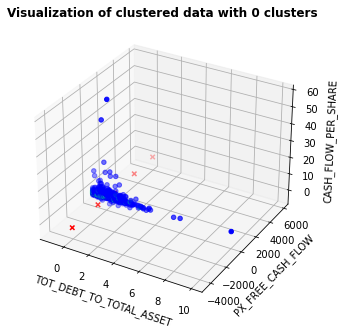

----------------------------------------------------------------------------------------------------


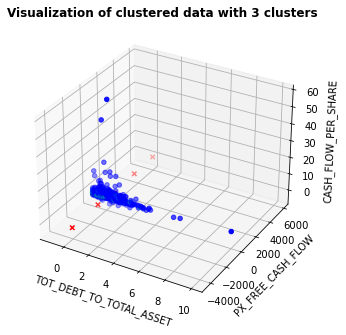

In [32]:

clusters = [0,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [33]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics

In [34]:
#getting the elbow plot to see what might be the right number of clusters

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20)

for k in K: #Building and fitting the model kmeanModel = KMeans(n_clusters=k).fit(X) kmeanModel.fit(X)
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                  'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
             'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

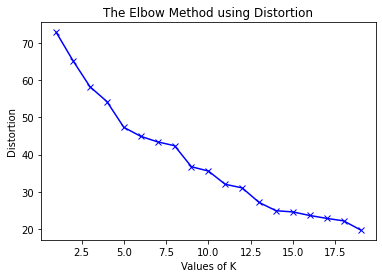

In [35]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

#can see the drastic change between 7.5 and 10

In [36]:
kmeans = KMeans(n_clusters = 7, random_state=55)
kmeans.fit(X)
y_pred = kmeans.predict(X)
print(y_pred)

[0 0 5 ... 0 0 0]


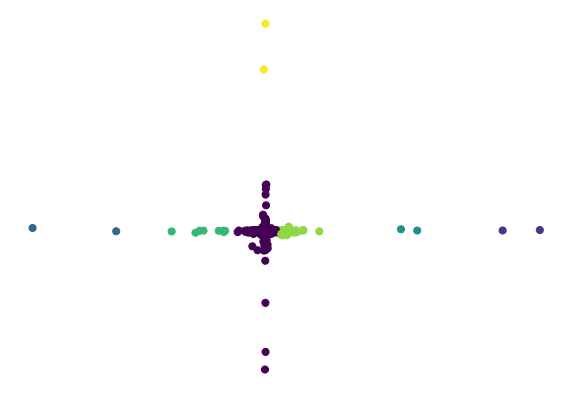

In [37]:
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,7))
colours = 'rbgymrck'
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred, s=50, cmap='viridis')
#for i in range(pca.shape[0]):
    #plt.text(pca[i,0], pca[i, 1], str(y_pred[i]),

             #color=colours[y_pred[i]],
             #fontdict={'weight': 'bold', 'size': 10}
        #)

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#

pca = PCA(n_components=7).fit_transform(X)
y_pred = KMeans(n_clusters=8, random_state=55).fit_predict(X)

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X,
    pca,
    test_size=0.2,
    random_state=55)


In [38]:
pd.Series(kmeans.labels_).value_counts() #check 1, 2,4, 5, 3 for outliers in net margin
#tried the clusters from 7 to 11 and chose 8

0    1442
5      28
4       8
6       2
3       2
2       2
1       2
dtype: int64

In [39]:
df['label'] = kmeans.labels_ #0-4(changable) above clusters #adding a label to a df
df['label'] = df['label'].astype(str)

In [40]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg 
    #shows the highest 

In [41]:
centroids.style.background_gradient() 

#on this table we see the average value for each cluster

In [42]:
#df_original[df['label'] == '5']

In [43]:
from sklearn import preprocessing

In [44]:
df['label'] = kmeans.labels_ 
#df['label'] = df['label'].astype(str)

In [45]:
#normalizing the data for a better and easier understanding of the differences between clusters
#MinMax scaler puts from 0-1

df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0))) 
df['label'] = kmeans.labels_

In [46]:
#a = np.array(df['netmargin']) #winsorizing the netmargin, cuz it's very high in value, almost all the data is 0.99

In [47]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg number for a cluster
centroids.style.background_gradient()

In [48]:
#print(df['netmargin'])

In [49]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg number for a cluster
centroids.style.background_gradient()

In [50]:
#df_original[df_original['netmargin']>2] #looking for outliers in netmargin, took out some of them and dropped them in the
#beginning, before the clustering.
#What I noticed is that the more outliers - companies I dropped the higher the netmargin numbers become. So my assumption is 
#that these tickers are stable, growth companies, that's why the netmargin might be good in comparison with other variables.
#I started to check for outliers from 10 (in the code above), but found outliers from # 7 and went down to 2, removed these tickers too from the clusters.
#They're in a special outliers classification and need futher investigation. 

In [51]:
pd.Series(kmeans.labels_).value_counts() 

0    1442
5      28
4       8
6       2
3       2
2       2
1       2
dtype: int64

In [52]:
df_original[df['label'] == 2] #checking what i have in label 1

ticker       revenue      pb         debt        assets  netmargin  \
23542     HL  2.249450e+08   0.993  533770000.0  2.637308e+09     -0.036   
32919   CHWY  1.354525e+09 -26.157  200439000.0  9.323210e+08     -0.045   

             ncfo     shareswa    sps       opinc  ...    netinccmn  fcfps  \
23542  57257000.0  502902000.0  0.447   7605000.0  ... -100109000.0 -0.001   
32919  74334000.0  401319000.0  3.375 -60597000.0  ... -252370000.0 -0.005   

       PX_TO_BOOK_RATIO RETURN_ON_ASSET   OPER_MARGIN  CASH_FLOW_PER_SHARE  \
23542             0.993       -0.037509   0.033808264             0.115545   
32919           -26.157       -0.307089  -0.044736716             0.186488   

       REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  \
23542           0.453939            -3390.0     0.690966   
32919           3.398206            -5302.0     0.266408   

       TOT_DEBT_TO_TOTAL_ASSET  
23542                 0.202392  
32919                 0.214989  

[2 rows x 31 columns]

In [53]:
df_original[df['label'] == 0] #the largest cluster, looking at the similarities in values among variables. 

ticker       revenue       pb          debt        assets  netmargin  \
16       ZUO  7.039300e+07   10.140  7.858800e+07  4.022270e+08     -0.337   
30       ZTS  1.674000e+09   23.279  6.611000e+09  1.154500e+10      0.229   
65      ZNGA  4.044630e+08    2.931  7.165100e+08  3.660614e+09     -0.009   
86        ZM  1.882510e+08   25.289  6.479200e+07  1.289845e+09      0.076   
159      ZEN  2.298710e+08   18.769  5.887460e+08  1.514589e+09     -0.157   
...      ...           ...      ...           ...           ...        ...   
40154    AAP  2.112614e+09    3.090  2.764479e+09  1.124852e+10      0.045   
40175   AAON  1.225740e+08    8.872  0.000000e+00  3.714240e+08      0.131   
40217    AAL  1.131300e+10 -106.470  3.344400e+10  5.999500e+10      0.037   
40238     AA  2.436000e+09    0.971  1.800000e+09  1.463100e+10     -0.124   
40257      A  1.357000e+09    5.282  2.462000e+09  9.501000e+09      0.145   

              ncfo     shareswa     sps        opinc  ...     netinccmn  \
16       4009000.0  113180000.0   0.622  -24449000.0  ... -8.339400e+07   
30     582000000.0  476412000.0   3.514  493000000.0  ...  1.500000e+09   
65      94049000.0  947733000.0   0.427    4332000.0  ...  4.192500e+07   
86      36554000.0  276679009.0   0.680   10553000.0  ...  2.175000e+07   
159     32211000.0  112517000.0   2.043  -32301000.0  ... -1.696530e+08   
...            ...          ...     ...          ...  ...           ...   
40154  158363000.0   69423000.0  30.431  126139000.0  ...  4.868960e+08   
40175   27342000.0   52060833.0   2.354   21430000.0  ...  5.371100e+07   
40217  600000000.0  438057971.0  25.825  729000000.0  ...  1.686000e+09   
40238  262000000.0  185572917.0  13.127 -108000000.0  ... -1.125000e+09   
40257  -59000000.0  310000000.0   4.377  215000000.0  ...  7.640000e+08   

       fcfps  PX_TO_BOOK_RATIO RETURN_ON_ASSET   OPER_MARGIN  \
16    -0.225            10.140       -0.243414  -0.347321467   
30     2.792            23.279        0.134270   0.294504182   
65     0.873             2.931        0.012826   0.010710498   
86     0.487            25.289        0.019134   0.056058135   
159    0.382            18.769       -0.117291  -0.140517943   
...      ...               ...             ...           ...   
40154  8.544             3.090        0.043565   0.059707547   
40175  1.168             8.872        0.155083   0.174833162   
40217 -0.911          -106.470        0.027648   0.064439141   
40238  1.654             0.971       -0.074250  -0.044334975   
40257  1.932             5.282        0.083497    0.15843773   

       CASH_FLOW_PER_SHARE  REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  \
16                0.035415           0.621846         -65.555556     1.454003   
30                1.221921           3.514597          47.403295     1.672204   
65                0.099426           0.427586           7.010309     1.933891   
86                0.132249           0.681077         156.673511     2.922532   
159               0.287149           2.049213         200.602094     1.277170   
...                    ...                ...                ...          ...   
40154             2.286520          30.502923          18.533474     0.247478   
40175             0.524823           2.352777          42.303082     1.995449   
40217             1.369682          25.825349         -31.481888     0.313145   
40238             1.411844          13.126915          13.004837     0.600468   
40257            -0.190210           4.374831          42.732919     1.158562   

       TOT_DEBT_TO_TOTAL_ASSET  
16                    0.195382  
30                    0.572629  
65                    0.195735  
86                    0.050232  
159                   0.388717  
...                        ...  
40154                 0.245764  
40175                 0.000000  
40217                 0.557446  
40238                 0.123026  
40257                 0.259131  

[1442 rows x 31 columns]

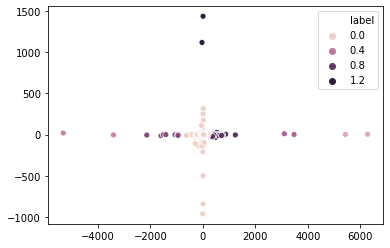

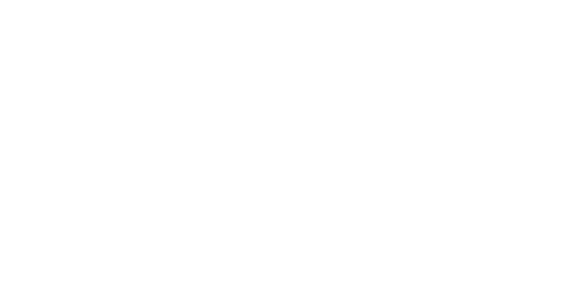

In [97]:
sns.scatterplot(x=pca[:, 0], y = pca[:, 1], hue = df['label'])
plt.figure(figsize = (10,5))
colors = 'rgbmc'


plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [55]:
df[df['label'] == 2] #filtered to row number 1 (cluster) #6 revenue per share is high 9-quick ratio, price for 
#cash flow is high too. #cash flow, quick ratio is okay, #10 is negative but not much debt, all therapies

#netmargin, oper margin 

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
23542                 0.064297           0.164847             0.058549   
32919                 0.068299           0.000000             0.059151   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  label  
23542         0.729354          0.597198     0.008176      2  
32919         0.596817          0.585859     0.002874      2

In [56]:
pd.Series(kmeans.labels_).value_counts() 

0    1442
5      28
4       8
6       2
3       2
2       2
1       2
dtype: int64

In [57]:
df_original[df['label'] == 3] #normalized data easy to compare among clusters

ticker      revenue      pb         debt        assets  netmargin  \
17015   MMSI  257922000.0   1.814  523748000.0  1.757321e+09     -0.016   
33519   CDLX   69293000.0  11.281      37000.0  2.243130e+08      0.049   

             ncfo    shareswa    sps      opinc  ...   netinccmn  fcfps  \
17015  26909000.0  55213000.0  4.671 -3410000.0  ...   5451000.0  0.010   
33519   4100000.0  26176000.0  2.647  1256000.0  ... -17144000.0  0.018   

       PX_TO_BOOK_RATIO RETURN_ON_ASSET   OPER_MARGIN  CASH_FLOW_PER_SHARE  \
17015             1.814        0.003139  -0.013221051             0.487404   
33519            11.281       -0.096916   0.018125929             0.159460   

       REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  \
17015           4.671752        3122.000000     1.154385   
33519           2.694997        3492.222222     2.422762   

       TOT_DEBT_TO_TOTAL_ASSET  
17015                 0.298038  
33519                 0.000165  

[2 rows x 31 columns]

In [58]:
df[df['label'] == 1] 

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
7953                  0.013812           0.926684             0.061459   
30098                 0.018493           1.000000             0.058068   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  label  
7953          0.726536          0.603135     0.100034      1  
30098         0.734303          0.602750     0.054420      1

In [59]:
df[df['label'] == 5] #filtering, df['label'] gives true and falses

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
51                    0.016176           0.488729             0.057929   
1666                  0.115752           0.486682             0.071146   
3943                  0.155384           0.518958             0.063443   
4048                  0.034814           0.508025             0.052292   
9062                  0.117162           0.502677             0.060853   
9627                  0.090966           0.515997             0.056946   
12458                 0.039262           0.565235             0.058727   
13723                 0.177448           0.492850             0.059307   
14411                 0.108379           0.500890             0.058165   
15508                 0.134485           0.486939             0.055571   
15600                 0.059496           0.533541             0.057841   
18107                 0.194542           0.484142             0.082421   
19758                 0.091770           0.500895             0.057489   
21354                 0.359282           0.504936             0.059061   
22128                 0.147616           0.533514             0.065215   
25212                 0.092444           0.510040             0.061164   
25929                 0.145081           0.507548             0.057154   
27490                 0.000000           0.510006             0.058853   
27585                 0.167012           0.489118             0.067097   
28541                 0.083259           0.491903             0.060441   
29486                 0.108936           0.484526             0.059720   
30953                 0.148554           0.492295             0.064568   
31121                 0.029620           0.523618             0.058518   
31226                 0.000000           0.519824             0.060297   
33246                 0.105291           0.484879             0.062266   
33695                 0.081096           0.495603             0.070202   
36639                 0.026389           0.495166             0.059438   
37498                 0.098550           0.490037             0.061423   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  label  
51            0.696721          0.606176     0.019275      5  
1666          0.764073          0.597985     0.004311      5  
3943          0.771854          0.597986     0.005142      5  
4048          0.786769          0.604778     0.018626      5  
9062          0.758015          0.598012     0.007567      5  
9627          0.724306          0.604712     0.020617      5  
12458         0.786948          0.601714     0.040050      5  
13723         0.677584          0.612775     0.034552      5  
14411         0.739430          0.612777     0.059774      5  
15508         0.714176          0.601103     0.035131      5  
15600         0.753735          0.599297     0.051776      5  
18107         0.758323          0.597297     0.005290      5  
19758         0.753018          0.598157     0.029418      5  
21354         0.777654          0.587435     0.099663      5  
22128         0.738075          0.597402     0.018462      5  
25212         0.765502          0.598063     0.018620      5  
25929         0.783205          0.599561     0.001724      5  
27490         0.702761          0.604027     0.025009      5  
27585         0.739330          0.598896     0.012322      5  
28541         0.751566          0.597611     0.018390      5  
29486         0.690709          0.607555     0.015640      5  
30953         0.758838          0.598788     0.016055      5  
31121         0.731901          0.601768     0.033587      5  
31226         0.682801          0.603850     0.026825      5  
33246         0.720035          0.597304     0.009329      5  
33695         0.780922          0.597312     0.000863      5  
36639         0.710066          0.601860     0.023401      5  
37498         0.825300          0.608638     0.011716      5

In [60]:
df[df['label'] == 7]  #profitable and cheap but have higher debt

Empty DataFrame
Columns: [TOT_DEBT_TO_TOTAL_ASSET, PX_FREE_CASH_FLOW, CASH_FLOW_PER_SHARE, RETURN_ON_ASSET, PX_TO_BOOK_RATIO, quick_ratio, label]
Index: []

In [61]:
df[df['label'] == 4] #cheaper than 7, no cash flow, profitable = oper margin, not diff with 7 but cheap, good for investments

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
10452                 0.000000           0.367025             0.059549   
11143                 0.086812           0.321171             0.060160   
17724                 0.097522           0.329046             0.071930   
18736                 0.066480           0.379605             0.064864   
22325                 0.000000           0.375642             0.077623   
27503                 0.163257           0.376981             0.057936   
33576                 0.037377           0.274234             0.059102   
35984                 0.059754           0.337065             0.058172   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  label  
10452         0.689756          0.597973     0.072406      4  
11143         0.679353          0.603166     0.023179      4  
17724         0.769579          0.597657     0.012564      4  
18736         0.746576          0.598252     0.017921      4  
22325         0.778054          0.597957     0.024419      4  
27503         0.700404          0.601785     0.044401      4  
33576         0.753862          0.598951     0.012754      4  
35984         0.740336          0.597284     0.012384      4

In [62]:
df[df['label'] == 6] #cost is higher = px free cash flow, 

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
18946                 0.279779           0.456019             0.082247   
20236                 0.161036           0.459420             0.080437   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  label  
18946         0.757053          0.132655     0.024924      6  
20236         0.817486          0.000000     0.004429      6

In [63]:
df[df['label'] == 0] 

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
16                    0.062070           0.451470             0.057869   
30                    0.181916           0.461208             0.067936   
65                    0.062182           0.457726             0.058412   
86                    0.015958           0.470629             0.058691   
159                   0.123490           0.474417             0.060005   
...                        ...                ...                  ...   
40154                 0.078076           0.458719             0.076968   
40175                 0.000000           0.460769             0.062021   
40217                 0.177093           0.454407             0.069189   
40238                 0.039084           0.458243             0.069547   
40257                 0.082322           0.460806             0.055955   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  label  
16            0.628123          0.601019     0.017705      0  
30            0.813808          0.606506     0.020430      0  
65            0.754101          0.598008     0.023698      0  
86            0.757202          0.607346     0.036045      0  
159           0.690130          0.604623     0.015497      0  
...                ...               ...          ...    ...  
40154         0.769214          0.598074     0.002638      0  
40175         0.824040          0.600489     0.024467      0  
40217         0.761388          0.552315     0.003458      0  
40238         0.711291          0.597189     0.007046      0  
40257         0.788846          0.598990     0.014016      0  

[1442 rows x 7 columns]

----------------------------------------------------------------------------------------------------


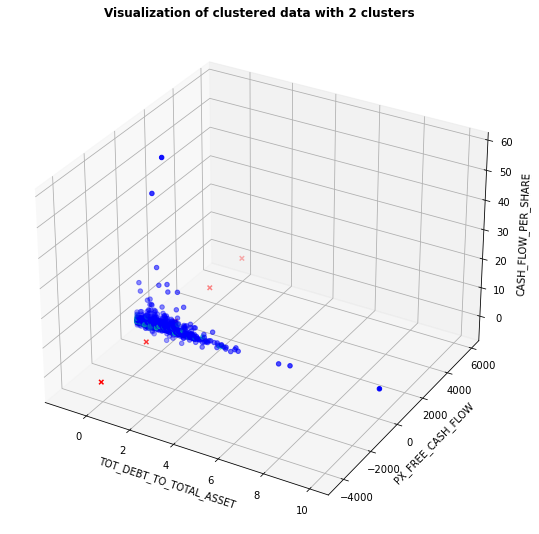

----------------------------------------------------------------------------------------------------


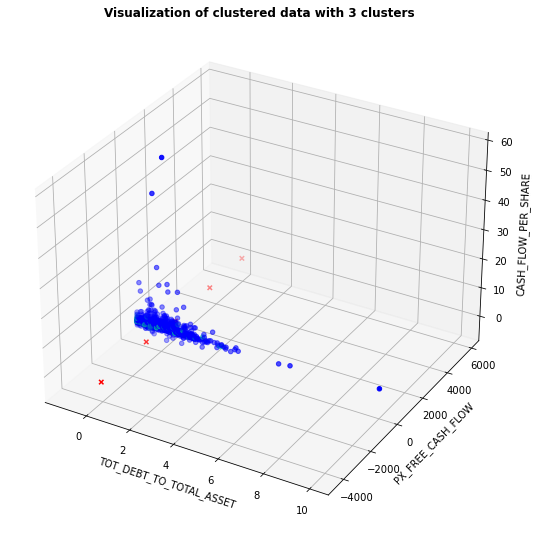

In [64]:
#Let's get to the fun part, visualizing our clusters! This will involve, in the non-PCA case, creating another 3D scatter plot,
#but in this instance,
#we will define the c parameter of our scatter to equal our model labels. This will correctly create the clusters for us.

clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure(figsize = (9, 7))
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [65]:
#let's see the other method of clustering: GaussianMixture, all the steps that i did above can be applied here too.

gauss = GaussianMixture(n_components=8, random_state=55)
gauss.fit(X)

GaussianMixture(n_components=8, random_state=55)

In [66]:
gauss.means_

array([[ 3.37042364e-01,  1.56231549e+01,  1.85806790e+00,
         2.08496691e-02,  6.05868971e+00,  1.87077227e+00,
         0.00000000e+00],
       [ 5.08435595e-02,  5.87148402e+03,  2.58722870e-01,
        -3.53421060e-02,  1.47460000e+01,  6.22010643e+00,
         1.00000000e+00],
       [ 2.08690621e-01, -4.34600000e+03,  1.51016125e-01,
        -1.72298894e-01, -1.25820000e+01,  4.78686699e-01,
         2.00000000e+00],
       [ 2.21495745e-01, -1.64402303e+03,  5.62477074e-01,
        -2.44338957e-02,  5.94000000e+00,  1.25501602e+00,
         4.00000000e+00],
       [ 1.49101350e-01,  3.30711111e+03,  3.23432113e-01,
        -4.68881770e-02,  6.54750000e+00,  1.78857384e+00,
         3.00000000e+00],
       [ 3.29252083e-01,  5.46450235e+02,  4.44629810e-01,
        -6.87549379e-03,  1.05094286e+01,  1.93269521e+00,
         5.00000000e+00],
       [ 6.93790215e-01,  6.93238447e+00,  2.80206395e+00,
         8.02907540e-02, -1.27006800e+03,  1.21148476e+00,
         6.0000000

In [67]:
prob_df = pd.DataFrame(gauss.predict_proba(X))
prob_df.shape

(1486, 8)

In [68]:
centroids = df.groupby(['label']).mean()

In [69]:
centroids.style.background_gradient() 

In [70]:
df = df.apply(lambda x: (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0)))

In [71]:
gauss = GaussianMixture(n_components=8, random_state=55)
gauss.fit(X)

GaussianMixture(n_components=8, random_state=55)

In [72]:
y_pred = gauss.predict(X)
print(y_pred)

[0 0 5 ... 0 0 0]


In [73]:
#df['label'] = gauss.l

In [74]:
#gauss.predict(X).value_counts()

In [75]:
#df['label'] = 
#gauss.predict(X)

In [76]:
#df['label'].value_counts()

In [77]:
#df['label'] = 
#pd.Series(gauss.predict(X)).value_counts() 


In [78]:
centroids = df.groupby(['label']).mean()

In [79]:
centroids.style.background_gradient() 

In [80]:
scipy.stats.entropy([0.731826, 0.267606, 5.687710e-04])


0.5855042262910504

In [81]:
prob_df['entropy'] = prob_df.apply(scipy.stats.entropy, axis=1)

In [82]:
prob_df.sort_values('entropy')

0    1    2    3    4    5    6         7   entropy
543   1.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000
806   1.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000
319   1.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000
1401  1.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000
1305  1.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000
...        ...  ...  ...  ...  ...  ...  ...       ...       ...
1022  0.937923  0.0  0.0  0.0  0.0  0.0  0.0  0.062077  0.232646
523   0.928575  0.0  0.0  0.0  0.0  0.0  0.0  0.071425  0.257310
1083  0.145202  0.0  0.0  0.0  0.0  0.0  0.0  0.854798  0.414295
1425  0.705541  0.0  0.0  0.0  0.0  0.0  0.0  0.294459  0.606096
1247  0.503282  0.0  0.0  0.0  0.0  0.0  0.0  0.496718  0.693126

[1486 rows x 9 columns]

In [83]:
df_original #have to add a new column 'label' to be able to see it on the plot in the original DF

ticker       revenue       pb          debt        assets  netmargin  \
16       ZUO  7.039300e+07   10.140  7.858800e+07  4.022270e+08     -0.337   
30       ZTS  1.674000e+09   23.279  6.611000e+09  1.154500e+10      0.229   
51        ZS  1.012680e+08   22.487  3.444200e+07  6.764250e+08     -0.288   
65      ZNGA  4.044630e+08    2.931  7.165100e+08  3.660614e+09     -0.009   
86        ZM  1.882510e+08   25.289  6.479200e+07  1.289845e+09      0.076   
...      ...           ...      ...           ...           ...        ...   
40154    AAP  2.112614e+09    3.090  2.764479e+09  1.124852e+10      0.045   
40175   AAON  1.225740e+08    8.872  0.000000e+00  3.714240e+08      0.131   
40217    AAL  1.131300e+10 -106.470  3.344400e+10  5.999500e+10      0.037   
40238     AA  2.436000e+09    0.971  1.800000e+09  1.463100e+10     -0.124   
40257      A  1.357000e+09    5.282  2.462000e+09  9.501000e+09      0.145   

              ncfo     shareswa     sps        opinc  ...     netinccmn  \
16       4009000.0  113180000.0   0.622  -24449000.0  ... -8.339400e+07   
30     582000000.0  476412000.0   3.514  493000000.0  ...  1.500000e+09   
51       5431000.0  128408000.0   0.789  -30280000.0  ... -6.374200e+07   
65      94049000.0  947733000.0   0.427    4332000.0  ...  4.192500e+07   
86      36554000.0  276679009.0   0.680   10553000.0  ...  2.175000e+07   
...            ...          ...     ...          ...  ...           ...   
40154  158363000.0   69423000.0  30.431  126139000.0  ...  4.868960e+08   
40175   27342000.0   52060833.0   2.354   21430000.0  ...  5.371100e+07   
40217  600000000.0  438057971.0  25.825  729000000.0  ...  1.686000e+09   
40238  262000000.0  185572917.0  13.127 -108000000.0  ... -1.125000e+09   
40257  -59000000.0  310000000.0   4.377  215000000.0  ...  7.640000e+08   

       fcfps  PX_TO_BOOK_RATIO RETURN_ON_ASSET   OPER_MARGIN  \
16    -0.225            10.140       -0.243414  -0.347321467   
30     2.792            23.279        0.134270   0.294504182   
51     0.153            22.487       -0.103884  -0.299008571   
65     0.873             2.931        0.012826   0.010710498   
86     0.487            25.289        0.019134   0.056058135   
...      ...               ...             ...           ...   
40154  8.544             3.090        0.043565   0.059707547   
40175  1.168             8.872        0.155083   0.174833162   
40217 -0.911          -106.470        0.027648   0.064439141   
40238  1.654             0.971       -0.074250  -0.044334975   
40257  1.932             5.282        0.083497    0.15843773   

       CASH_FLOW_PER_SHARE  REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  \
16                0.035415           0.621846         -65.555556     1.454003   
30                1.221921           3.514597          47.403295     1.672204   
51                0.042444           0.791419         366.601307     1.579705   
65                0.099426           0.427586           7.010309     1.933891   
86                0.132249           0.681077         156.673511     2.922532   
...                    ...                ...                ...          ...   
40154             2.286520          30.502923          18.533474     0.247478   
40175             0.524823           2.352777          42.303082     1.995449   
40217             1.369682          25.825349         -31.481888     0.313145   
40238             1.411844          13.126915          13.004837     0.600468   
40257            -0.190210           4.374831          42.732919     1.158562   

       TOT_DEBT_TO_TOTAL_ASSET  
16                    0.195382  
30                    0.572629  
51                    0.050918  
65                    0.195735  
86                    0.050232  
...                        ...  
40154                 0.245764  
40175                 0.000000  
40217                 0.557446  
40238                 0.123026  
40257                 0.259131  

[1486 rows x 31 columns]

In [84]:
df_original['label'] = kmeans.labels_ #adding a new column 'label' to the original df

In [85]:
from ipywidgets import interact

In [86]:
px.scatter(data_frame=df_original, x='RETURN_ON_ASSET', y='quick_ratio', color = 'label', hover_data=['ticker', 'netmargin', 'PX_FREE_CASH_FLOW'])

In [87]:
df_original #see the label col in the end:)

ticker       revenue       pb          debt        assets  netmargin  \
16       ZUO  7.039300e+07   10.140  7.858800e+07  4.022270e+08     -0.337   
30       ZTS  1.674000e+09   23.279  6.611000e+09  1.154500e+10      0.229   
51        ZS  1.012680e+08   22.487  3.444200e+07  6.764250e+08     -0.288   
65      ZNGA  4.044630e+08    2.931  7.165100e+08  3.660614e+09     -0.009   
86        ZM  1.882510e+08   25.289  6.479200e+07  1.289845e+09      0.076   
...      ...           ...      ...           ...           ...        ...   
40154    AAP  2.112614e+09    3.090  2.764479e+09  1.124852e+10      0.045   
40175   AAON  1.225740e+08    8.872  0.000000e+00  3.714240e+08      0.131   
40217    AAL  1.131300e+10 -106.470  3.344400e+10  5.999500e+10      0.037   
40238     AA  2.436000e+09    0.971  1.800000e+09  1.463100e+10     -0.124   
40257      A  1.357000e+09    5.282  2.462000e+09  9.501000e+09      0.145   

              ncfo     shareswa     sps        opinc  ...  fcfps  \
16       4009000.0  113180000.0   0.622  -24449000.0  ... -0.225   
30     582000000.0  476412000.0   3.514  493000000.0  ...  2.792   
51       5431000.0  128408000.0   0.789  -30280000.0  ...  0.153   
65      94049000.0  947733000.0   0.427    4332000.0  ...  0.873   
86      36554000.0  276679009.0   0.680   10553000.0  ...  0.487   
...            ...          ...     ...          ...  ...    ...   
40154  158363000.0   69423000.0  30.431  126139000.0  ...  8.544   
40175   27342000.0   52060833.0   2.354   21430000.0  ...  1.168   
40217  600000000.0  438057971.0  25.825  729000000.0  ... -0.911   
40238  262000000.0  185572917.0  13.127 -108000000.0  ...  1.654   
40257  -59000000.0  310000000.0   4.377  215000000.0  ...  1.932   

       PX_TO_BOOK_RATIO  RETURN_ON_ASSET   OPER_MARGIN CASH_FLOW_PER_SHARE  \
16               10.140        -0.243414  -0.347321467            0.035415   
30               23.279         0.134270   0.294504182            1.221921   
51               22.487        -0.103884  -0.299008571            0.042444   
65                2.931         0.012826   0.010710498            0.099426   
86               25.289         0.019134   0.056058135            0.132249   
...                 ...              ...           ...                 ...   
40154             3.090         0.043565   0.059707547            2.286520   
40175             8.872         0.155083   0.174833162            0.524823   
40217          -106.470         0.027648   0.064439141            1.369682   
40238             0.971        -0.074250  -0.044334975            1.411844   
40257             5.282         0.083497    0.15843773           -0.190210   

       REVENUE_PER_SHARE  PX_FREE_CASH_FLOW  quick_ratio  \
16              0.621846         -65.555556     1.454003   
30              3.514597          47.403295     1.672204   
51              0.791419         366.601307     1.579705   
65              0.427586           7.010309     1.933891   
86              0.681077         156.673511     2.922532   
...                  ...                ...          ...   
40154          30.502923          18.533474     0.247478   
40175           2.352777          42.303082     1.995449   
40217          25.825349         -31.481888     0.313145   
40238          13.126915          13.004837     0.600468   
40257           4.374831          42.732919     1.158562   

       TOT_DEBT_TO_TOTAL_ASSET  label  
16                    0.195382      0  
30                    0.572629      0  
51                    0.050918      6  
65                    0.195735      0  
86                    0.050232      0  
...                        ...    ...  
40154                 0.245764      0  
40175                 0.000000      0  
40217                 0.557446      0  
40238                 0.123026      0  
40257                 0.259131      0  

[1486 rows x 32 columns]

In [88]:
@interact
def plotting(x=df_original.columns, y = df_original.columns):
    fig = px.scatter(data_frame=df_original, x= x, y= y, color = 'label', hover_data=['ticker', 'PX_TO_BOOK_RATIO', 'CASH_FLOW_PER_SHARE'])
    fig.show()

interactive(children=(Dropdown(description='x', options=('ticker', 'revenue', 'pb', 'debt', 'assets', 'netmarg…


TOT_DEBT_TO_TOTAL_ASSET = The debt to total assets ratio is an indicator of a company's financial leverage. It tells you the percentage of a company's total assets that were financed by creditors. ... Debt is the total amount of all liabilities (current liabilities and long-term liabilities).

PX_TO_BOOK_RATIO = Measures the ratio between [MarketCap] and [EquityUSD]. 

RETURN_ON_ASSET = ROA, Return on equity measures a corporation's profitability by calculating the amount of [NetIncCmn] returned as a percentage of [EquityAvg].

OPER_MARGIN = Operating margin is a profitability ratio that shows how much profit a company makes from its core operations in relation to the total revenues it brings in. 

CASH_FLOW_PER_SHARE = Free Cash Flow per Share is a valuation metric calculated by dividing [FCF] by [SharesWA] and [ShareFactor].

PX_FREE_CASH_FLOW = The price-to-cash flow (P/CF) ratio is a stock valuation indicator or multiple that measures the value of a stock’s price relative to its operating cash flow per share. The ratio uses operating cash flow which adds back non-cash expenses such as depreciation and amortization to net income. It is especially useful for valuing stocks that have positive cash flow but are not profitable because of large non-cash charges.

QUICK RATIO = Quick Ratio = an indicator of a company's short-term liquidity position and measures a company's ability to meet its short-term obligations with its most liquid assets

NETMARGIN = Measures the ratio between a company's [NetIncCmn] and [Revenue].

LABEL 1 has a pretty high price per cash flow value, meaning that the stock price is high for these companies and the companies 
are very profitable. Let's see which stocks these are.

And here you're, two companies which went parabollic in just a year: Shopify(from $100 to $1106 per share) and newly created IPO Datadog(from $30 to $118)

Revenues are high. (Revenue = any activities that constitute an earning process). 

Assets are very high too, in billions, which is very rare among companies.
Very little debt.

The quick ratio is high too, which is very important.

Operating margin is slightly negative. (Operating margin is a profitability ratio that shows how much profit a company makes from its core operations in relation to the total revenues it brings in. Earnings before interest and taxes (EBIT) is the same metric as operating income and can be used in calculating operating margin)

In [89]:
df[df['label'] == 4] #lets see the cleaned data and compare values.

Empty DataFrame
Columns: [TOT_DEBT_TO_TOTAL_ASSET, PX_FREE_CASH_FLOW, CASH_FLOW_PER_SHARE, RETURN_ON_ASSET, PX_TO_BOOK_RATIO, quick_ratio, label]
Index: []

In [90]:
df[df['label']==1] 

TOT_DEBT_TO_TOTAL_ASSET  PX_FREE_CASH_FLOW  CASH_FLOW_PER_SHARE  \
18946                 0.279779           0.456019             0.082247   
20236                 0.161036           0.459420             0.080437   

       RETURN_ON_ASSET  PX_TO_BOOK_RATIO  quick_ratio  label  
18946         0.757053          0.132655     0.024924    1.0  
20236         0.817486          0.000000     0.004429    1.0

Lets see the label 3, the PX_FREE_CASH_FLOW is very low on the pairplot. 
Wow, indeed, very big negative numbers, different from other clusters.
This cluster is interesting, the price range differs from $70 to $300 and the lowest price of $5 among them is BB, worth to look into it later on. Very big gap. 

In [91]:
df_original[df['label']==3] 

Empty DataFrame
Columns: [ticker, revenue, pb, debt, assets, netmargin, ncfo, shareswa, sps, opinc, assetsc, liabilitiesc, price, calendardate, datekey, sharesbas, equity, receivables, investmentsc, cashneq, assetsavg, netinccmn, fcfps, PX_TO_BOOK_RATIO, RETURN_ON_ASSET, OPER_MARGIN, CASH_FLOW_PER_SHARE, REVENUE_PER_SHARE, PX_FREE_CASH_FLOW, quick_ratio, TOT_DEBT_TO_TOTAL_ASSET, label]
Index: []

[0 rows x 32 columns]

uff, I see PX_TO_BOOK_RATIO (pb = price to book ratio, measures the ration between MarketCap and Revenue) is super low at CHWY - this might be an outlier here - spotted! No price per cash flow either. 
HL = $ 5
CHWY = $ 66 

In [92]:
df_original[df['label']==2] 

Empty DataFrame
Columns: [ticker, revenue, pb, debt, assets, netmargin, ncfo, shareswa, sps, opinc, assetsc, liabilitiesc, price, calendardate, datekey, sharesbas, equity, receivables, investmentsc, cashneq, assetsavg, netinccmn, fcfps, PX_TO_BOOK_RATIO, RETURN_ON_ASSET, OPER_MARGIN, CASH_FLOW_PER_SHARE, REVENUE_PER_SHARE, PX_FREE_CASH_FLOW, quick_ratio, TOT_DEBT_TO_TOTAL_ASSET, label]
Index: []

[0 rows x 32 columns]

Cluster 6 seems like a week, negative cluster, let's check the price to book ratio, it's in the tail among other clusters on PX PX_TO_BOOK_RATIO and on PX_FREE_CASH_FLOW

In [93]:
df_original[df['label']=='6'] 

c:\users\gaukharjavarova\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Empty DataFrame
Columns: [ticker, revenue, pb, debt, assets, netmargin, ncfo, shareswa, sps, opinc, assetsc, liabilitiesc, price, calendardate, datekey, sharesbas, equity, receivables, investmentsc, cashneq, assetsavg, netinccmn, fcfps, PX_TO_BOOK_RATIO, RETURN_ON_ASSET, OPER_MARGIN, CASH_FLOW_PER_SHARE, REVENUE_PER_SHARE, PX_FREE_CASH_FLOW, quick_ratio, TOT_DEBT_TO_TOTAL_ASSET, label]
Index: []

[0 rows x 32 columns]

<Figure size 648x504 with 0 Axes>

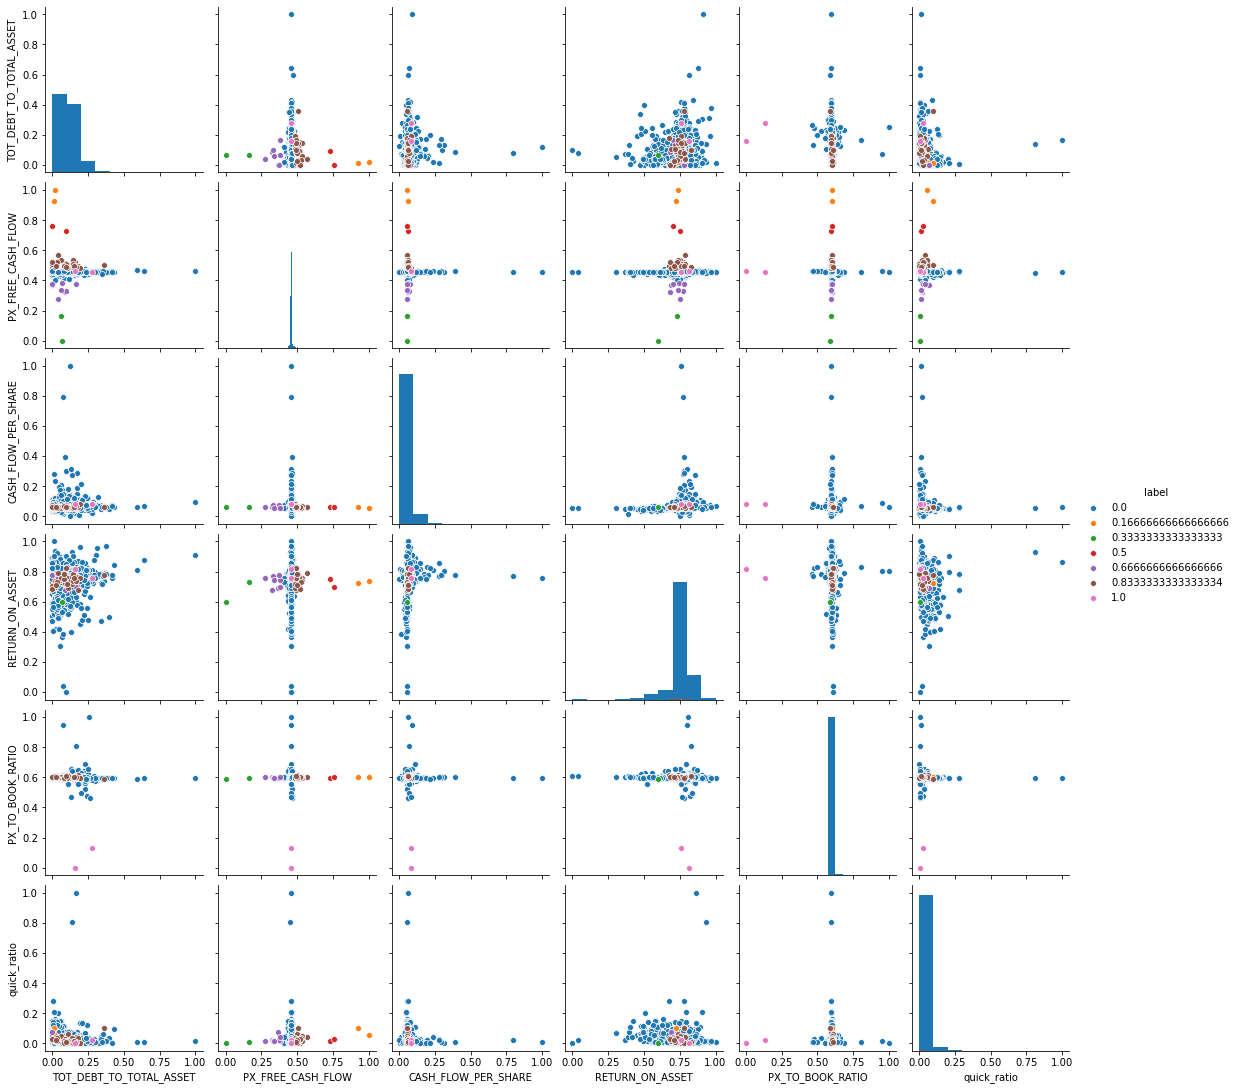

<Figure size 648x504 with 0 Axes>

In [94]:
sns.pairplot(df, hue="label", diag_kind="hist")
plt.figure(figsize=(9,7))
#very interesting.. We can actually see the clusters very distintcly at some plots.
#amazing tool for futher investigation. 
#on price per cash flow column can see distinguished clusters.


In [95]:
set(y_pred) #no repeated list = set

{0, 1, 2, 3, 4, 5, 6, 7}

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 16 to 40257
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TOT_DEBT_TO_TOTAL_ASSET  1486 non-null   float64
 1   PX_FREE_CASH_FLOW        1486 non-null   float64
 2   CASH_FLOW_PER_SHARE      1486 non-null   float64
 3   RETURN_ON_ASSET          1486 non-null   float64
 4   PX_TO_BOOK_RATIO         1486 non-null   float64
 5   quick_ratio              1486 non-null   float64
 6   label                    1486 non-null   float64
dtypes: float64(7)
memory usage: 124.9 KB
